In [1]:
using DifferentialEquations, DataFrames
using Plots, CSV, XLSX, StatsPlots
using Optim, DiffEqParamEstim, Turing, Distributions
# First time takes a while

In [2]:
PATH_TO_MODELS = pwd()*"/models/"
PATH_TO_OUTPUT = pwd()*"/output/" # Path for output data, plots
FILENAME = "outputMM.csv" # Filename for output data
PLOTNAME = "plottraces.pdf"
MODELNAME = "TXTL_MM.jl"
include(PATH_TO_MODELS*MODELNAME);

## 1. Solve model

### Saturation kinetics model

\begin{align}
\dot{d} &= 0 \\
\dot{m} &= V_{maxTX} \alpha(t) \frac{d}{d+K_{TX}} - k_{deg}m \\
\dot{P} &= V_{maxTL} \alpha(t) \frac{m}{m+K_{TL}} - k_{mat}P \\
\dot{P_{mat}} &= k_{mat}P \\
\dot{\alpha} &= -\lambda \alpha \\
\end{align}

### Set up and solve ODEs

In [3]:
# Set up ODEs
u0 = valuesVar
params = valuesPar
tspan = 0,Float64(12*60) # time in min
prob = ODEProblem(model!,u0,tspan,params);

In [4]:
# Solve ODEs
# first time takes a while
sol_ODE = solve(prob,saveat=10);

### Output results

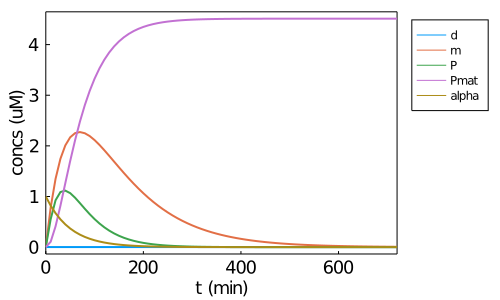

In [5]:
# Plot options

fntsm = Plots.font("sans-serif", pointsize=round(8.0))
fntlg = Plots.font("sans-serif", pointsize=round(12.0))
default(titlefont=fntlg, guidefont=fntlg, tickfont=fntlg, legendfont=fntsm)
p = plot(grid=:false,legend=:true,framestyle=:frame,size=(500,300))

# Plot data
plot!(sol_ODE, lw=2, labels=permutedims(keysVar),legend = :outertopright) 
plot!(xaxis = "t (min)",yaxis="concs (uM)")


In [6]:
# Example script to save plot and data

# Save plot
savefig(PATH_TO_OUTPUT*PLOTNAME)

# Save data
CSV.write(PATH_TO_OUTPUT*FILENAME,sol_ODE)

"/run/media/Storage HD/Nadanai/Archlinux/Repos/nllab-MolletVRes/output/outputMM.csv"

## 2. Simulate model in microfluidic device

### Encode experimental protocol in callbacks

In [7]:
function marktime!(integrator)   
end

function condition(u,t,integrator) 
    t%INTERVAL_DIL # condition true when t is multiple of dilution interval
end

function dilute!(integrator)
    if integrator.t<SWITCHTIMES[1]
        # Stage 1
        INDEX_REFRESH = [idx_d,idx_A]
        CONC_REFRESH = [d0,A0]
        
        # first dilute everything
        for j in 1:NSPECIES
            integrator.u[j] = integrator.u[j]*(1-DIL_FRAC)
        end
        
        # then refresh appropriate species: here DNA and system activity A refreshed
        for j in 1:size(INDEX_REFRESH)[1]
            integrator.u[INDEX_REFRESH[j]] = integrator.u[INDEX_REFRESH[j]] + DIL_FRAC*CONC_REFRESH[j]
        end
        
    elseif SWITCHTIMES[1]<=integrator.t
        # Stage 2 - right now same as Stage 1
        INDEX_REFRESH = [idx_d,idx_A]
        CONC_REFRESH = [d0,A0]
        
        # first dilute everything
        for j in 1:NSPECIES
            integrator.u[j] = integrator.u[j]*(1-DIL_FRAC)
        end
        
        # then refresh appropriate species: here DNA and system activity A refreshed
        for j in 1:size(INDEX_REFRESH)[1]
            integrator.u[INDEX_REFRESH[j]] = integrator.u[INDEX_REFRESH[j]] + DIL_FRAC*CONC_REFRESH[j]
        end
        
    end
end

function solvemodel(grads,u0,params,TMAX,INTERVAL_DIL,tsave,DIL_FRAC,NSPECIES,SWITCHTIMES)
    tspan = (0.0,TMAX); 
    prob = ODEProblem(grads,u0,tspan,params);

    # Callbacks

    contcb = ContinuousCallback(condition,dilute!;save_positions=(false,false))
    periodcb = PeriodicCallback(marktime!,INTERVAL_DIL;save_positions=(false,false)) # hack to mark time points for dilution
    cb = CallbackSet(periodcb,contcb)

    # Solve
    sol = solve(prob, callback=cb,saveat=tsave);
    return(sol) # Return trajectories
end

solvemodel (generic function with 1 method)

### Simulate

In [8]:
# Global simulation settings
TMAX = 12.0*60 # in minutes
INTERVAL_DIL = 15.0 # in minutes
DIL_FRAC = 0.2;
NSPECIES = 5
SWITCHTIMES = [120] # Time to swap between experimental stages, in minutes

# 1. Define names for species indices
idx_d=1;
idx_m=2;
idx_P=3;
idx_Pmat=4;
idx_A=5;

# 2. Set initial conditions and parameters
d0=0.001;
m0=0.0;
P0=2.0;
Pmat0=0.0;
A0=1.0;

Vmaxtx=1.0;
KTX=0.01;
kdeg=0.01;
Vmaxtl=0.1;
KTL=0.1;
kmat=0.03;
lamb=0.02;

u0 = [d0,m0,P0,Pmat0,A0];
params = [Vmaxtx,KTX,kdeg,Vmaxtl,KTL,kmat,lamb];

In [9]:
# 3. Solve

# Save data frequently e.g. every 2 minutes to observe sawtooth behaviour:
TSAVE = collect(0:2:TMAX) 

# Or save at each dilution step to see smooth trace (similar to experiment):
#TSAVE = collect(0:INTERVAL_DIL:TMAX) 

solU,solDU=solvemodel(model!,u0,params,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES);
t = solU.t;
d = [datum for subarr in solU.u for datum in subarr[idx_d]];
m = [datum for subarr in solU.u for datum in subarr[idx_m]];
P = [datum for subarr in solU.u for datum in subarr[idx_P]];
Pmat = [datum for subarr in solU.u for datum in subarr[idx_Pmat]];
A = [datum for subarr in solU.u for datum in subarr[idx_A]];

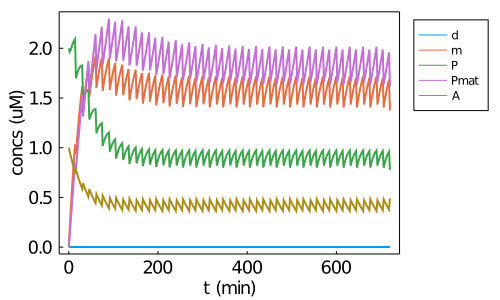

In [10]:
# Plot options

fntsm = Plots.font("sans-serif", pointsize=round(8.0))
fntlg = Plots.font("sans-serif", pointsize=round(12.0))
default(titlefont=fntlg, guidefont=fntlg, tickfont=fntlg, legendfont=fntsm)
p = plot(grid=:false,legend=:true,framestyle=:frame,size=(500,300))

# Plot data
plot!(t,d, lw=2, labels="d",legend = :outertopright) 
plot!(t,m, lw=2, labels="m") 
plot!(t,P, lw=2, labels="P") 
plot!(t,Pmat, lw=2, labels="Pmat") 
plot!(t,A, lw=2, labels="A") 
plot!(xaxis = "t (min)",yaxis="concs (uM)")

The following are valid modifications of the experimental program:

* increase number of experimental stages
* change dilution interval
* pure dilution (without refreshing DNA and activity)
* change input DNA concentration 
* measure mRNA simultaneously with Pmat

More complex devices can also change dilution fraction but we don't yet have those in the lab.

## 3. Calibrate model to titration data

In [11]:
# Get data (more info about experiment in data folder)

PATH_TO_DATA = "./data/"
xf = XLSX.readxlsx(PATH_TO_DATA*"data_capacity_in_nM.xlsx")
sheetname = XLSX.sheetnames(xf)[1]

sh = xf[sheetname]
data = sh[:]

t = data[2:end,1]*60 # convert time to minutes
y = data[2:end,2:10]
dy = data[2:end,12:20]

conds = [
60.3,
44.5,
22.25,
11.125,
5.5625,
2.78125,
1.390625,
0.6953125,
0.34765625]

# Each trajectory can be taken as follows:
ydata=y[:,1];

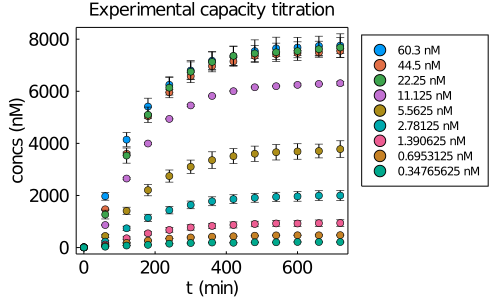

In [12]:
# Plot options

fntsm = Plots.font("sans-serif", pointsize=round(8.0))
fntlg = Plots.font("sans-serif", pointsize=round(12.0))
default(titlefont=fntlg, guidefont=fntlg, tickfont=fntlg, legendfont=fntsm)
p = plot(grid=:false,legend=:true,framestyle=:frame,size=(500,300))

# Plot every trajectory
for idx in 1:size(conds)[1]
    scatter!(t,y[:,idx], yerror=dy[:,idx], lw=2, 
        labels=string(conds[idx])*" nM",legend = :outertopright) 
end

plot!(xaxis = "t (min)",yaxis="concs (nM)", title="Experimental capacity titration")

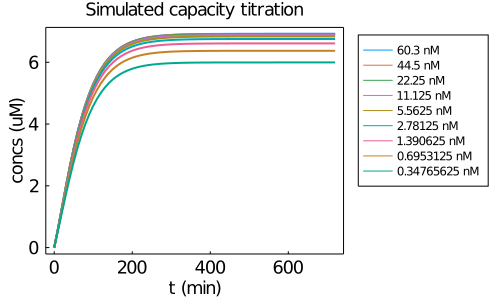

In [13]:
# Set up model to simulate titration (in batch, no microfluidics)

d0=0.001;
m0=0.0;
P0=2.0;
Pmat0=0.0;
A0=1.0;

Vmaxtx=1.0;
KTX=0.01;
kdeg=0.01;
Vmaxtl=0.1;
KTL=0.1;
kmat=0.03;
lamb=0.02;

u0 = [d0,m0,P0,Pmat0,A0];
params = [Vmaxtx,KTX,kdeg,Vmaxtl,KTL,kmat,lamb];

tspan = 0,Float64(12*60) # time in min
prob = ODEProblem(model!,u0,tspan,params);

# Solve ODEs
prob = ODEProblem(model!,u0,tspan,params)

# Plot options

fntsm = Plots.font("sans-serif", pointsize=round(8.0))
fntlg = Plots.font("sans-serif", pointsize=round(12.0))
default(titlefont=fntlg, guidefont=fntlg, tickfont=fntlg, legendfont=fntsm)
pl = plot(grid=:false,legend=:true,framestyle=:frame,size=(500,300))

for idx in 1:size(conds)[1]
    
    modprob = remake(prob, p=params, u0=[conds[idx]/1000,m0,P0,Pmat0,A0])
    sol = solve(modprob,saveat=10);
    tsim = sol.t
    Pmat = [datum for subarr in sol.u for datum in subarr[idx_Pmat]];
    plot!(tsim,Pmat, lw=2, 
        labels=string(conds[idx])*" nM",legend = :outertopright) 
end

plot!(xaxis = "t (min)",yaxis="concs (uM)", title="Simulated capacity titration")

The aim is to vary model parameters such that simulated data agrees with experimental data. I will demonstrate for just one trajectory; in the end the entire data set should be used.

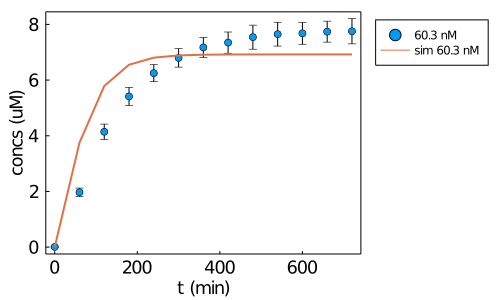

In [14]:
# Experimental data for 60.3 nM
ydata=y[:,1]/1000; # in uM
ystdev=dy[:,1]/1000; # in uM

# Model output for 60.3 nM
dsel = 60.3/1000 # DNA concentration in uM
modprob = remake(prob, p=params, u0=[dsel,m0,P0,Pmat0,A0])
sol = solve(modprob,saveat=60);
tsim = sol.t
Pmat = [datum for subarr in sol.u for datum in subarr[idx_Pmat]];

# Plot comparison
fntsm = Plots.font("sans-serif", pointsize=round(8.0))
fntlg = Plots.font("sans-serif", pointsize=round(12.0))
default(titlefont=fntlg, guidefont=fntlg, tickfont=fntlg, legendfont=fntsm)
pl = plot(grid=:false,legend=:true,framestyle=:frame,size=(500,300))

scatter!(t,ydata, yerror=ystdev, lw=2, 
    labels="60.3 nM",legend = :outertopright)
plot!(tsim,Pmat, lw=2, 
        labels="sim 60.3 nM",legend = :outertopright) 
plot!(xaxis = "t (min)",yaxis="concs (uM)")

In [15]:
# Define simple L2 cost function
params = [Vmaxtx,KTX,kdeg,Vmaxtl,KTL,kmat,lamb]
u0=[dsel,m0,P0,Pmat0,A0]
prob = ODEProblem(model!,u0,tspan,params)

cost_function = build_loss_objective(prob, Tsit5(),
                L2Loss(tsim,ydata),
    maxiters=10000000,verbose=true,save_idxs=4) # save only observable protein output

# Check to see if cost function evaluates
cost_function(params)

10.592180770907586

Best fit params: [1.5048670178577808, 0.00910313299098545, -0.0064440154659771605, 0.10361598037132659, 0.11895462669778561, 0.00965146807639961, 0.018055425021167394]

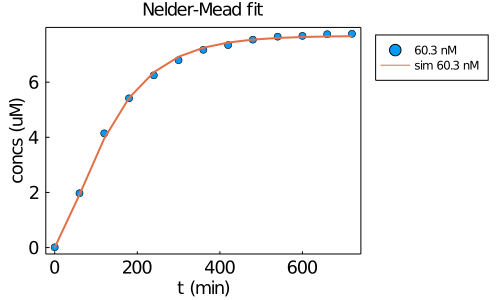

In [16]:
# Local optimization example (Nelder-Mead)

result = optimize(cost_function,params,iterations=100)
paramsfit=Optim.minimizer(result)

mod_prob = remake(prob, p=paramsfit)
mod_sol = solve(mod_prob, Tsit5(), saveat=60, verbose=true,maxiters=1000000,save_idxs=4)
ymodelfit = Array(mod_sol)

# Plot comparison
fntsm = Plots.font("sans-serif", pointsize=round(8.0))
fntlg = Plots.font("sans-serif", pointsize=round(12.0))
default(titlefont=fntlg, guidefont=fntlg, tickfont=fntlg, legendfont=fntsm)
pl = plot(grid=:false,legend=:true,framestyle=:frame,size=(500,300))

scatter!(t,ydata, lw=2, 
    labels="60.3 nM",legend = :outertopright)
plot!(tsim,ymodelfit, lw=2, 
        labels="sim 60.3 nM",legend = :outertopright) 
plot!(xaxis = "t (min)",yaxis="concs (uM)", title="Nelder-Mead fit")

print("Best fit params: ", paramsfit)
pl


The fit appears good but notice some of the parameters are negative, which may be unphysical. The possible parameter ranges can be constrained to be positive, or (a better solution) you can fit the log-parameter values instead.

SAMIN results
==> WARNING <==
Last point satisfies convergence criteria, but is near
boundary of parameter space.
13 out of  175 evaluations were out of bounds in the last round.
Expand bounds and re-run, unless this is a constrained minimization.
total number of objective function evaluations: 72626

     Obj. value:      0.0141436051

       parameter      search width
         0.46344           0.00000 
         0.10000           0.00000 
         0.01300           0.00000 
         0.47307           0.00000 
         1.00000           0.00000 
         0.00746           0.00000 
         0.04518           0.00000 

Best fit params: [0.4634388394170698, 0.09999999999999104, 0.012997714589608422, 0.4730737924328584, 0.9999999999999941, 0.007458555907771868, 0.04518024370321594]

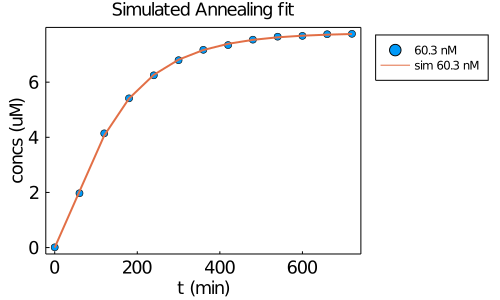

In [17]:
# Global optimization example (Simulated Annealing with bounds)

lowerbounds = params*0.0
upperbounds = params*10.0
result = optimize(cost_function,lowerbounds,upperbounds,params, SAMIN(), 
    Optim.Options(iterations=100000,time_limit=100)) 
paramsfit=Optim.minimizer(result)

mod_prob = remake(prob, p=paramsfit)
mod_sol = solve(mod_prob, Tsit5(), saveat=60, verbose=true,maxiters=1000000,save_idxs=4)
ymodelfit = Array(mod_sol)

# Plot comparison
fntsm = Plots.font("sans-serif", pointsize=round(8.0))
fntlg = Plots.font("sans-serif", pointsize=round(12.0))
default(titlefont=fntlg, guidefont=fntlg, tickfont=fntlg, legendfont=fntsm)
pl = plot(grid=:false,legend=:true,framestyle=:frame,size=(500,300))

scatter!(t,ydata, lw=2, 
    labels="60.3 nM",legend = :outertopright)
plot!(tsim,ymodelfit, lw=2, 
        labels="sim 60.3 nM",legend = :outertopright) 
plot!(xaxis = "t (min)",yaxis="concs (uM)", title="Simulated Annealing fit")

print("Best fit params: ", paramsfit)
pl


Global optimizers are preferred because we know our system has many local minima. However they are very expensive computationally and also require fine-tuning.

In [18]:
# Bayesian example

Turing.setadbackend(:forwarddiff) # Details here: forwarddiff ok for small models, for 
                                  # larger models require adjoint 

# Define our probabilistic model
@model function fitlv(data)
    σ ~ InverseGamma(2, 3) 
    Vmaxtx ~ truncated(Normal(1.0,0.5),0,10) # mean, sigma, lower bound, upper bound
    KTX ~ truncated(Normal(0.01,0.005),0,0.1)
    kdeg ~ truncated(Normal(0.01,0.005),0,0.1)
    Vmaxtl ~ truncated(Normal(0.1,0.05),0,1)
    KTL ~ truncated(Normal(0.1,0.05),0,1)
    kmat ~ truncated(Normal(0.03,0.015),0,0.3)
    lamb ~ truncated(Normal(0.02,0.01),0,0.2)
    
    params = [Vmaxtx,KTX,kdeg,Vmaxtl,KTL,kmat,lamb] # Draw parameters from prior distribution
    prob = ODEProblem(model!,u0,tspan,params)
    predicted = solve(prob,Tsit5(),saveat=60,save_idxs=4) 

    for i = 1:length(predicted)
        data[i] ~ Normal(predicted[i], σ) # generate synthetic data with σ-normal distribution noise
    end
end

modelbayes = fitlv(ydata) # Fit model to synthetic data generated earlier
chain = sample(modelbayes, NUTS(.65),1000) # No U turn sampler

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/nadanai/.julia/packages/Turing/O1Pn0/src/inference/hmc.jl:195
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:17


Chains MCMC chain (1000×20×1 Array{Float64,3}):

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1
Samples per chain = 1000
parameters        = KTL, KTX, Vmaxtl, Vmaxtx, kdeg, kmat, lamb, σ
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat 
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64 

         KTL    0.1019    0.0488     0.0015    0.0051    86.7736    1.0011
         KTX    0.0105    0.0049     0.0002    0.0002   411.7258    0.9993
      Vmaxtl    0.1099    0.0437     0.0014    0.0037   106.0293    1.0366
      Vmaxtx    1.0152    0.4659     0.0147    0.0303   370.2877    1.0052
        kdeg    0.0100    0.0046     0.0001    0.0003   325.2236    0.9990
        kmat    0.0111    0.0039     

For Bayesian inference we must propose an initial distribution ('prior') for our parameters. Here we have taken normal distributions around the initial parameter values, truncated within bounds as for the global optimizer. There are more sophisticated ways to set up priors. 

The result is a posterior distribution over the parameters, whose samples are given in a chain object. We can interrogate this object to view the distributions.

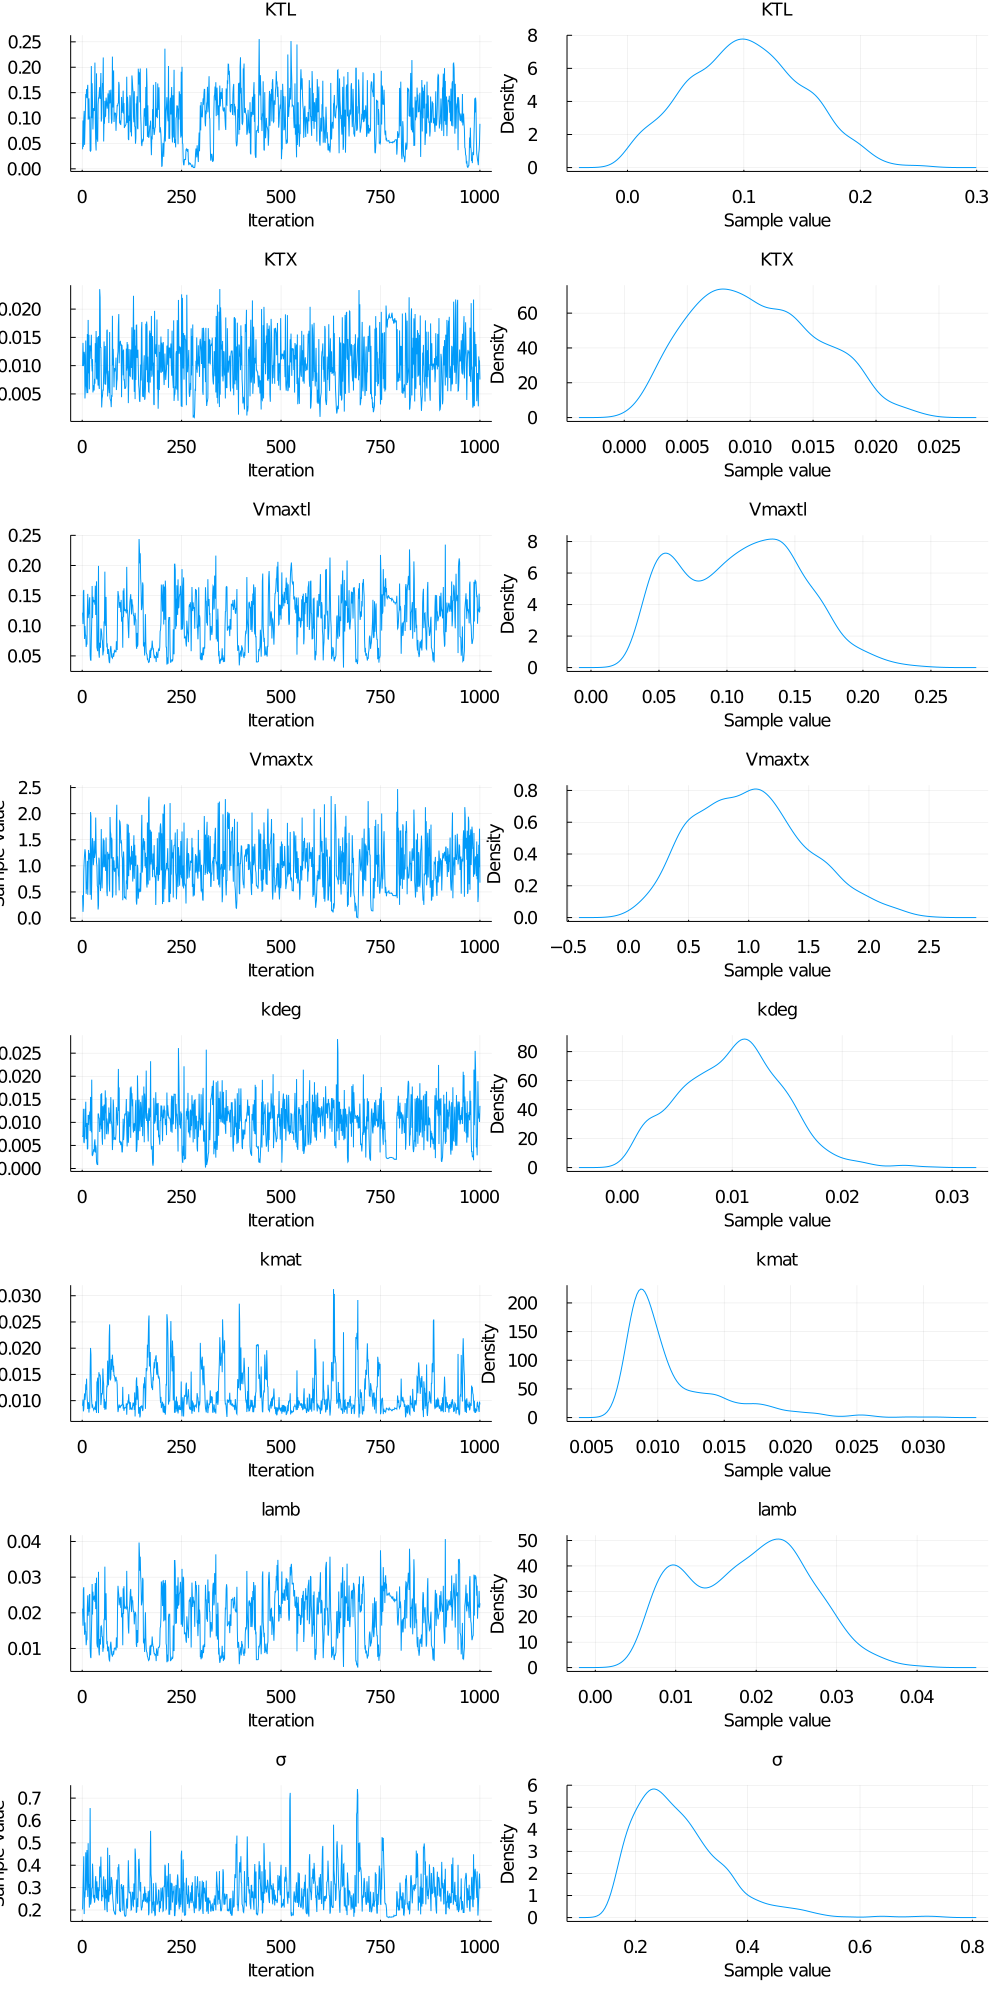

In [19]:
# The chain object contains the samples from the posterior distribution
# For example the samples for parameter KTX can be accessed:
# a = Array(chain[:KTX]);

# The StatsPlots package handles chains automatically. 
# You can get density plots
# plot(chain[:KTX],seriestype=:density)

# Or even a summary of the entire chain object
plot(chain)

In [20]:
# Let's convert the chain to a dataframe and use this to 
# obtain samples, to plot an ensemble model result
dfc=DataFrame(chain);
print(names(dfc))
samples = [dfc[!,:Vmaxtx] dfc[!,:KTX]  dfc[!,:kdeg] dfc[!,:Vmaxtl] dfc[!,:KTL] dfc[!,:kmat] dfc[!,:lamb]];

["iteration", "chain", "KTL", "KTX", "Vmaxtl", "Vmaxtx", "acceptance_rate", "hamiltonian_energy", "hamiltonian_energy_error", "is_accept", "kdeg", "kmat", "lamb", "log_density", "lp", "max_hamiltonian_energy_error", "n_steps", "nom_step_size", "numerical_error", "step_size", "tree_depth", "σ"]

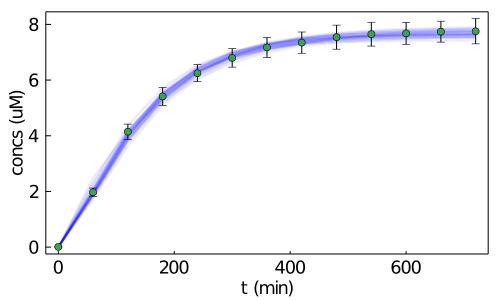

In [21]:
# Experimental data for 60.3 nM
ydata=y[:,1]/1000; # in uM
ystdev=dy[:,1]/1000; # in uM

# Model output for 60.3 nM
dsel = 60.3/1000 # DNA concentration in uM
u0=[dsel,m0,P0,Pmat0,A0]
params = [Vmaxtx,KTX,kdeg,Vmaxtl,KTL,kmat,lamb];
prob = ODEProblem(model!,u0,tspan,params)

# Plot comparison
fntsm = Plots.font("sans-serif", pointsize=round(8.0))
fntlg = Plots.font("sans-serif", pointsize=round(12.0))
default(titlefont=fntlg, guidefont=fntlg, tickfont=fntlg, legendfont=fntsm)
pl = plot(grid=:false,legend=:false,framestyle=:frame,size=(500,300))

# Run simulation 50 times with random parameter values drawn from posterior distribution
for j in 1:50
    modprob = remake(prob, p=samples[rand(1:1000),:], u0=[dsel,m0,P0,Pmat0,A0])
    sol = solve(modprob,saveat=60);
    tsim = sol.t 
    Pmat = [datum for subarr in sol.u for datum in subarr[idx_Pmat]];
    plot!(tsim,Pmat, lw=2, alpha=0.05, color="blue") 
end

scatter!(t,ydata, yerror=ystdev, lw=2)

plot!(xaxis = "t (min)",yaxis="concs (uM)")

Such an ensemble plot is generated by running the simulation multiple times using parameter values drawn from the posterior distribution, and allows us to visualise the parameter uncertainty directly in comparison to our experimental data. It is the preferred way to represent models whose parameters are inferred using Bayesian techniques.

Notice that here we have not yet done a proper treatment of experimental uncertainty. 